In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

In [2]:
# Получаем HOG-дескриптор для изображения
def compute_hog_descriptor_from_patch(img):
    img = cv2.resize(img, (64, 128))
    gx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=1)
    gy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=1)
    magnitude, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)
    angle = np.mod(angle, 180)

    num_bins = 9
    angle_quantized = np.floor(angle / 20).astype(int)
    angle_quantized[angle_quantized >= num_bins] = num_bins - 1

    cell_size = 8
    cells_x = img.shape[1] // cell_size
    cells_y = img.shape[0] // cell_size
    hog = np.zeros((cells_y, cells_x, num_bins), dtype=np.float32)

    for y in range(cells_y):
        for x in range(cells_x):
            cell_mag = magnitude[y*cell_size:(y+1)*cell_size, x*cell_size:(x+1)*cell_size]
            cell_angle = angle_quantized[y*cell_size:(y+1)*cell_size, x*cell_size:(x+1)*cell_size]
            for i in range(cell_size):
                for j in range(cell_size):
                    bin_idx = cell_angle[i, j]
                    hog[y, x, bin_idx] += cell_mag[i, j]
          
    block_size = 2
    eps = 1e-6
    hog_normalized = []
    for y in range(cells_y - block_size + 1):
        for x in range(cells_x - block_size + 1):
            block = hog[y:y+block_size, x:x+block_size, :].flatten()
            norm = np.linalg.norm(block) + eps
            hog_normalized.append(block / norm)

    return np.concatenate(hog_normalized)          

In [3]:
# Делим исходное изображение на окна
def sliding_window(image, step_size, window_size):
    for y in range(0, image.shape[0] - window_size[1] + 1, step_size):
        for x in range(0, image.shape[1] - window_size[0] + 1, step_size):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

In [4]:
# Pyramid
def pyramid(image, scale=1.5, min_size=(64, 128)):
    yield image
    while True:
        w = int(image.shape[1] / scale)
        h = int(image.shape[0] / scale)
        image = cv2.resize(image, (w, h))
        if image.shape[0] < min_size[1] or image.shape[1] < min_size[0]:
            break
        yield image

In [11]:
# Загружаем датасет
def load_dataset(positive_dir, negative_dir):
    X, y = [], []
    for path in Path(positive_dir).glob('*.jpg'):
        img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Не удалось загрузить: {path}")
            continue
        X.append(compute_hog_descriptor_from_patch(img))
        y.append(1)
    for path in Path(negative_dir).glob('*.jpg'):
        img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Не удалось загрузить: {path}")
            continue
        X.append(compute_hog_descriptor_from_patch(img))
        y.append(0)
    return np.array(X), np.array(y)

In [5]:
# Детектируем объекты (людей) своей реализацией HOG
def detect_objects_with_custom_hog(image, clf, scaler, threshold=0.5, step_size=16, window_size=(64, 128)):
    detections = []
    for resized in pyramid(image):
        scale_x = image.shape[1] / resized.shape[1]
        scale_y = image.shape[0] / resized.shape[0]
        gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
        for (x, y, window) in sliding_window(gray, step_size, window_size):
            if window.shape[0] != 128 or window.shape[1] != 64:
                continue
            hog_vec = compute_hog_descriptor_from_patch(window)
            hog_vec = scaler.transform([hog_vec])
            score = clf.decision_function(hog_vec)[0]
            if score > threshold:
                rx = int(x * scale_x)
                ry = int(y * scale_y)
                rw = int(window_size[0] * scale_x)
                rh = int(window_size[1] * scale_y)
                detections.append((rx, ry, rw, rh))
    return detections

In [6]:
# Уменьшаем большое количество дублирующихся перекрывающихся окон
def non_max_suppression_fast(boxes, overlap_thresh=0.3):
    if len(boxes) == 0:
        return []
    boxes = np.array(boxes)
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,0] + boxes[:,2]
    y2 = boxes[:,1] + boxes[:,3]
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    pick = []
    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        suppress = [last]
        for pos in range(0, last):
            j = idxs[pos]
            xx1 = max(x1[i], x1[j])
            yy1 = max(y1[i], y1[j])
            xx2 = min(x2[i], x2[j])
            yy2 = min(y2[i], y2[j])
            w = max(0, xx2 - xx1 + 1)
            h = max(0, yy2 - yy1 + 1)
            overlap = (w * h) / areas[j]
            if overlap > overlap_thresh:
                suppress.append(pos)
        idxs = np.delete(idxs, suppress)
    return boxes[pick].astype(int).tolist()

In [7]:
# Отрисовываем окна
def draw_detections(image, detections):
    for (x, y, w, h) in detections:
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    return image

Загрузка и обучение...
Классы: (array([0, 1]), array([1538,  902]))
              precision    recall  f1-score   support

           0       0.89      0.81      0.85       308
           1       0.72      0.83      0.77       180

    accuracy                           0.82       488
   macro avg       0.81      0.82      0.81       488
weighted avg       0.83      0.82      0.82       488



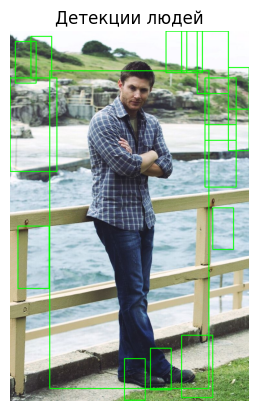

In [12]:
# Обучаем модель и проверяем на изображении не из обучающего датасета
if __name__ == "__main__":
    pos_dir = './additional/person/Pos'
    neg_dir = './additional/person/Neg'

    print("Загрузка и обучение...")
    X, y = load_dataset(pos_dir, neg_dir)
    print("Классы:", np.unique(y, return_counts=True))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    clf = LinearSVC(C=0.1, max_iter=10000)
    clf.fit(X_train, y_train)
    print(classification_report(y_test, clf.predict(X_test)))

    test_img = cv2.imread('./additional/person/test2.jpg')
    detections = detect_objects_with_custom_hog(test_img, clf, scaler, threshold=0.5)
    detections = non_max_suppression_fast(detections, overlap_thresh=0.3)
    result = draw_detections(test_img.copy(), detections)

    # Сохраняем и показываем
    cv2.imwrite('./additional/person/result2.jpg', result)
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.title("Детекции людей")
    plt.axis('off')
    plt.show()

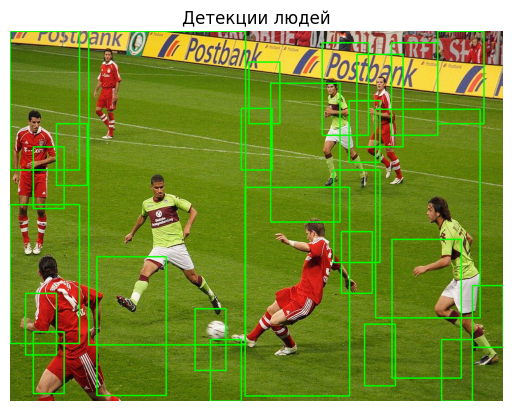

In [14]:
test_img = cv2.imread('./additional/person/test1.jpg')
detections = detect_objects_with_custom_hog(test_img, clf, scaler, threshold=0.5)
detections = non_max_suppression_fast(detections, overlap_thresh=0.3)
result = draw_detections(test_img.copy(), detections)

# Сохраняем и показываем
cv2.imwrite('./additional/person/result1.jpg', result)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title("Детекции людей")
plt.axis('off')
plt.show()

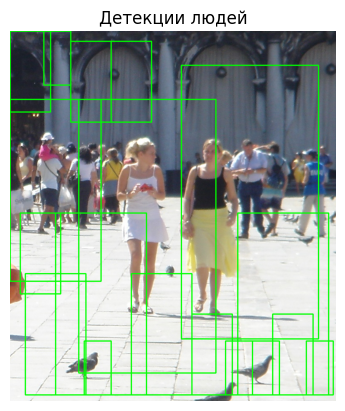

In [23]:
test_img = cv2.imread('./additional/person/test6.jpg')
detections = detect_objects_with_custom_hog(test_img, clf, scaler, threshold=0.5)
detections = non_max_suppression_fast(detections, overlap_thresh=0.3)
result = draw_detections(test_img.copy(), detections)

# Сохраняем и показываем
cv2.imwrite('./additional/person/result6.jpg', result)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title("Детекции людей")
plt.axis('off')
plt.show()

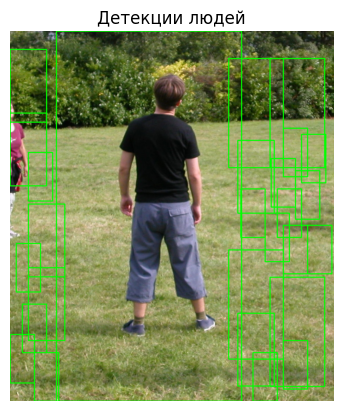

In [24]:
test_img = cv2.imread('./additional/person/test5.jpg')
detections = detect_objects_with_custom_hog(test_img, clf, scaler, threshold=0.5)
detections = non_max_suppression_fast(detections, overlap_thresh=0.3)
result = draw_detections(test_img.copy(), detections)

# Сохраняем и показываем
cv2.imwrite('./additional/person/result5.jpg', result)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title("Детекции людей")
plt.axis('off')
plt.show()

Попробуем реализацию метода HOG из OpenCV, чтобы понять: проблема в обучающем датасете или реализации метода?

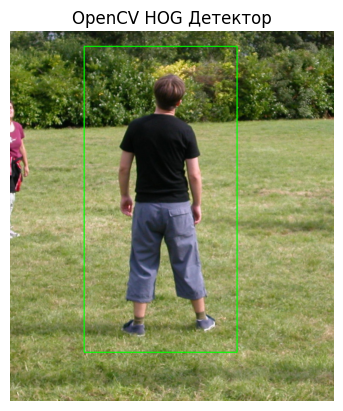

In [19]:
import cv2
import matplotlib.pyplot as plt

# Загружаем изображение
image = cv2.imread('./additional/person/test5.jpg')
orig = image.copy()

# Инициализируем HOG-детектор
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

# Детектируем людей
(rects, weights) = hog.detectMultiScale(image, winStride=(8, 8), padding=(8, 8), scale=1.05)

# Отрисовываем прямоугольники
for (x, y, w, h) in rects:
    cv2.rectangle(orig, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Сохраняем и показываем
cv2.imwrite('./additional/person/opencv_result5.jpg', orig)
plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
plt.title("OpenCV HOG Детектор")
plt.axis('off')
plt.show()

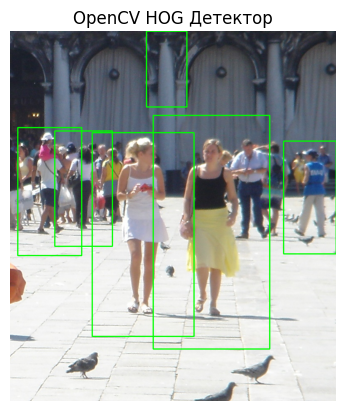

In [21]:
# Загружаем изображение
image = cv2.imread('./additional/person/test6.jpg')
orig = image.copy()

# Инициализируем HOG-детектор
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

# Детектируем людей
(rects, weights) = hog.detectMultiScale(image, winStride=(8, 8), padding=(8, 8), scale=1.05)

# Отрисовываем прямоугольники
for (x, y, w, h) in rects:
    cv2.rectangle(orig, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Сохраняем и показываем
cv2.imwrite('./additional/person/opencv_result6.jpg', orig)
plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
plt.title("OpenCV HOG Детектор")
plt.axis('off')
plt.show()

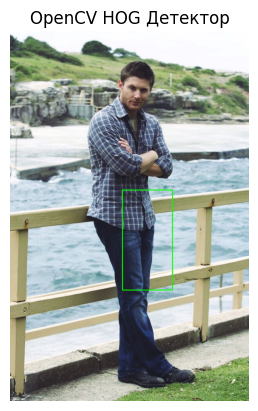

In [22]:
# Загружаем изображение
image = cv2.imread('./additional/person/test2.jpg')
orig = image.copy()

# Инициализируем HOG-детектор
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

# Детектируем людей
(rects, weights) = hog.detectMultiScale(image, winStride=(8, 8), padding=(8, 8), scale=1.05)

# Отрисовываем прямоугольники
for (x, y, w, h) in rects:
    cv2.rectangle(orig, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Сохраняем и показываем
cv2.imwrite('./additional/person/opencv_result2.jpg', orig)
plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
plt.title("OpenCV HOG Детектор")
plt.axis('off')
plt.show()

Выводы so far: моя реализация имеет проблемы с детекцией даже на тех изображениях, на которых обучалась. Вот в чём проблема, как мне кажется: во-первых датасет для обучения подбирался самостоятельно (люди на изображениях в самых разных позах и количествах, разные размеры фото) + модель обучается по принципу классификации: если на изображении, по мнению модели, есть человек и он в папке Positive, то ответ засчитывается за правильный, однако она могла считать пейзаж за человека, его часть, задетектить не всех людей и никак это не проверяется.

Реализация из OpenCV справляется получше, но только с изображениями людей, приближенными к тем,что были в INRIA Person dataset, а они были такие:

(np.float64(-0.5), np.float64(1049.5), np.float64(601.5), np.float64(-0.5))

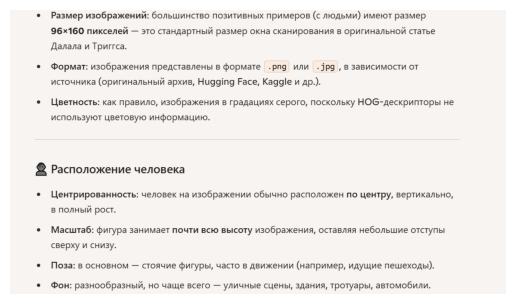

In [26]:
import matplotlib.image as mpimg
img = mpimg.imread('./additional/inria.png')  # путь к файлу
plt.imshow(img)
plt.axis('off')  # убрать оси

Соответсвенно, варианты действий: обучить свою реализацию по другому принципу или переобучить реализацию из OpenCV на другом датасете с более разнообразными изображениями людей.